# Цель эксперимента:
Решить задачу классификации на выборке "SemEval 2015". Используемые модели: логистическая регрессия на центроидах векторов предложений, SVM, KNN, решающие деревья. 

Используемые критерии качества: ROC AUC, PR кривая, сложность модели.

Структурные параметры: глубина и структура деревьев, параметры регуляризации логистической регрессии и SVM, количество соседей в KNN

Критерии качества: F1 - мера

# Описание данных
Данные представляют собой таблицу с 3 колонками. Во 2 и 3 столбце находятся 2 предложения на английском языке из заголовков новостей, подписей к изображениям, ответов учащихся и ответов на форумах. В 1 столбце стоит оценка сходства этих предложений от 0 (не имеют отношения) до 5 (семантическая эквивалентность).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.preprocessing import normalize, label_binarize
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import fasttext
import nltk
nltk.download('punkt')

import io
from operator import add
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package punkt to /home/yashart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Загрузка данных

In [2]:
data = pd.read_csv('data.csv', sep='\t', header=None, error_bad_lines=False)
data.head()

b'Skipping line 6281: expected 3 fields, saw 5\nSkipping line 7594: expected 3 fields, saw 4\nSkipping line 22828: expected 3 fields, saw 4\nSkipping line 34320: expected 3 fields, saw 5\nSkipping line 40352: expected 3 fields, saw 4\nSkipping line 40353: expected 3 fields, saw 4\nSkipping line 52160: expected 3 fields, saw 4\nSkipping line 52163: expected 3 fields, saw 4\n'


,0,1,2
0,2,A switch will affect a bulb it the bulb and th...,When the switch and the bulb are contained in ...
1,1,The switch determines whether the path is open...,If a bulb and a switch are in the same path th...
2,0,because there is a gap,Terminal 1 and the positive terminal are separ...
3,0,not contained insa me path,A and B have their own path
4,3,a rank or position relative to others,take or have a position relative to others.


# Гистограмма первого столбца

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febbd7fb940>]],
      dtype=object)

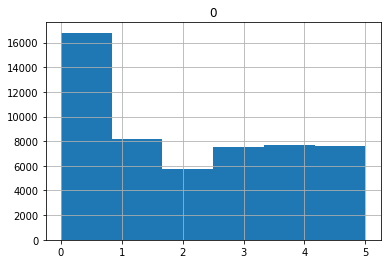

In [3]:
data.hist(bins=6)

### Как заметно на графике, большинство предложений в выборке не связанны между собой. Количество пар предложений с коэффициентами подобия 1, 2, 3, 4, 5 примерно одинаково

# Анализ пропусков

In [4]:
data.isnull().any()

0    False
1    False
2     True
dtype: bool

In [5]:
data.isna().any()

0    False
1    False
2     True
dtype: bool

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53552 entries, 0 to 53551
Data columns (total 3 columns):
0    53552 non-null int64
1    53552 non-null object
2    53534 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


### Выборка имеет пропуски во втором столбце, строки с ними удаляем

In [7]:
data = data.dropna()

In [8]:
data.isnull().any()

0    False
1    False
2    False
dtype: bool

In [9]:
data.isna().any()

0    False
1    False
2    False
dtype: bool

# Перевод предложений в форму для анализа с использованием векторов предложений английского языка.

## (UPD) Я использовал pretrained model для simplified english из-за меньшего размера модели и отсутствию достаточного количества оперативной памяти на рабочем пк.

In [10]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = [float(token) for token in tokens[1:]]
    return data

In [11]:
fastTextModel = load_vectors('wiki.simple.vec')

In [12]:
data1 = []
for sequence1 in data[1]:
    tokens = nltk.word_tokenize(sequence1)
    vector = []
    wordsNums = 0
    for token in tokens:
        if token in fastTextModel:
            wordsNums += 1
            if wordsNums == 1:
                vector = fastTextModel[token]
            else:
                vector = [vector[i] + (fastTextModel[token])[i] for i in range(0, len(vector))]

    vector = [x / wordsNums for x in vector]

    data1.append(vector)


In [13]:
data1Pandas = pd.DataFrame(data=data1)
data1Pandas.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.041805,-0.075551,0.086595,-0.221745,0.049698,0.327926,-0.119440,-0.009601,0.022672,-0.001835,...,0.016054,-0.139608,0.031250,0.079283,-0.083964,0.026459,-0.282504,-0.039693,-0.086172,-0.207858
1,0.116783,0.017724,0.089273,-0.239869,0.123415,0.224407,-0.141931,-0.035286,0.029514,0.103091,...,0.012018,-0.229586,-0.126136,0.132932,-0.086329,0.058214,-0.247456,0.025174,-0.061585,-0.252064
2,0.095518,-0.083431,0.152000,-0.360500,0.177394,0.299246,-0.077063,-0.026326,0.148533,0.109087,...,0.023595,-0.141712,-0.067767,-0.028061,-0.129487,0.055781,-0.224432,-0.029646,-0.191087,-0.114553
3,0.134428,-0.064073,0.167495,-0.292917,0.041421,0.117234,-0.060676,-0.011699,0.101043,0.142907,...,0.115770,-0.255680,-0.094371,-0.026798,-0.059796,0.042292,-0.046980,0.013283,-0.116802,-0.118928
4,0.158426,-0.018740,0.183370,-0.241824,0.164232,0.129662,-0.123529,-0.010511,-0.014409,0.040690,...,0.004868,-0.221039,-0.084491,0.041919,-0.021942,0.075617,-0.276474,-0.106039,-0.104348,-0.074792


In [14]:
data2 = []
for sequence2 in data[2]:
    tokens = nltk.word_tokenize(sequence2)
    vector = []
    wordsNums = 0
    for token in tokens:
        if token in fastTextModel:
            wordsNums += 1
            if wordsNums == 1:
                vector = list(fastTextModel[token])
            else:
                vector = [vector[i] + (fastTextModel[token])[i] for i in range(0, len(vector))]

    vector = [x / wordsNums for x in vector]
    
    data2.append(vector)


In [15]:
data2Pandas = pd.DataFrame(data=data2)

In [16]:
data.columns = ['labels', 'text1', 'text2']
cleanDataFrame = pd.concat([data1Pandas, data2Pandas, data['labels']], axis=1, sort=False)

In [17]:
cleanDataFrame = cleanDataFrame.dropna()
cleanDataFrame.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,labels
0,0.041805,-0.075551,0.086595,-0.221745,0.049698,0.327926,-0.119440,-0.009601,0.022672,-0.001835,...,-0.171884,0.031532,0.035311,-0.100389,0.038077,-0.204991,-0.033625,-0.054880,-0.210176,2.0
1,0.116783,0.017724,0.089273,-0.239869,0.123415,0.224407,-0.141931,-0.035286,0.029514,0.103091,...,-0.141500,0.020389,0.062220,-0.076832,0.008534,-0.249507,-0.014810,-0.046243,-0.219965,1.0
2,0.095518,-0.083431,0.152000,-0.360500,0.177394,0.299246,-0.077063,-0.026326,0.148533,0.109087,...,-0.122036,-0.013295,0.022548,-0.152667,0.144898,-0.155924,0.036698,-0.092041,-0.172830,0.0
3,0.134428,-0.064073,0.167495,-0.292917,0.041421,0.117234,-0.060676,-0.011699,0.101043,0.142907,...,-0.313408,-0.033434,0.039315,-0.121034,-0.042523,-0.181927,-0.124978,0.001263,-0.157525,0.0
4,0.158426,-0.018740,0.183370,-0.241824,0.164232,0.129662,-0.123529,-0.010511,-0.014409,0.040690,...,-0.194292,-0.094475,0.041129,-0.068172,0.033419,-0.242180,-0.083911,-0.144645,-0.081769,3.0


### Получаем таблицу с 601 колонкой, где 300 певых колонок - вектор первого предложения, вторые 300 - вектор 2-ого предложения, последняя колонка - коэффициент подобия

# Список моделей:



Для решения поставленной задачи используются следующие модели:

- Логистическая регрессия
- SVM
- KNN
- Decision Tree

# Критерии качества:

Precision-Recall-кривая

# Разбиение выборки на обучение и контроль 70% на 30%

In [18]:
# restart kernel because lack of memory
cleanDataFrame.to_csv('clean_data.csv')

In [2]:
cleanDataFrame = pd.read_csv('clean_data.csv')
cleanDataFrame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,291.1,292.1,293.1,294.1,295.1,296.1,297.1,298.1,299.1,labels
0,0,0.041805,-0.075551,0.086595,-0.221745,0.049698,0.327926,-0.119440,-0.009601,0.022672,...,-0.171884,0.031532,0.035311,-0.100389,0.038077,-0.204991,-0.033625,-0.054880,-0.210176,2.0
1,1,0.116783,0.017724,0.089273,-0.239869,0.123415,0.224407,-0.141931,-0.035286,0.029514,...,-0.141500,0.020389,0.062220,-0.076832,0.008534,-0.249507,-0.014810,-0.046243,-0.219965,1.0
2,2,0.095518,-0.083431,0.152000,-0.360500,0.177394,0.299246,-0.077063,-0.026326,0.148533,...,-0.122036,-0.013295,0.022548,-0.152667,0.144898,-0.155924,0.036698,-0.092041,-0.172830,0.0
3,3,0.134428,-0.064073,0.167495,-0.292917,0.041421,0.117234,-0.060676,-0.011699,0.101043,...,-0.313408,-0.033434,0.039315,-0.121034,-0.042523,-0.181927,-0.124978,0.001263,-0.157525,0.0
4,4,0.158426,-0.018740,0.183370,-0.241824,0.164232,0.129662,-0.123529,-0.010511,-0.014409,...,-0.194292,-0.094475,0.041129,-0.068172,0.033419,-0.242180,-0.083911,-0.144645,-0.081769,3.0


In [4]:
cleanDataFrame.info()
cleanDataFrame = cleanDataFrame[:3000]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52844 entries, 0 to 52843
Columns: 602 entries, Unnamed: 0 to labels
dtypes: float64(601), int64(1)
memory usage: 242.7 MB


In [5]:
y = cleanDataFrame['labels']
X = cleanDataFrame.drop(['labels', 'Unnamed: 0'], axis=1)
#y = preprocessing.label_binarize(y, classes=[0, 1, 2, 3, 4, 5])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2100, 600), (2100,), (900, 600), (900,))

# Логистическая регрессия

In [121]:
classifier = LogisticRegression()
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

parameters_grid = {
    'C' : [0.1, 1, 5, 10, 100],
}

grid_cv = GridSearchCV(classifier, parameters_grid, cv=cv)


In [122]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 5, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [123]:
best_param = grid_cv.best_params_["C"]
best_param

1

In [124]:
pred = grid_cv.predict(X_test)

In [125]:
fbeta = metrics.precision_recall_fscore_support(y_test, pred)[2]

In [126]:
print (np.mean(metrics.precision_recall_fscore_support(y_test, pred)[0]))
print (np.mean(metrics.precision_recall_fscore_support(y_test, pred)[1]))
print (np.mean(fbeta))

0.37844982083905315
0.3273830208338535
0.32437485292139046


f-мера - 0.17647231747069025, оптимальный параметр C - 1

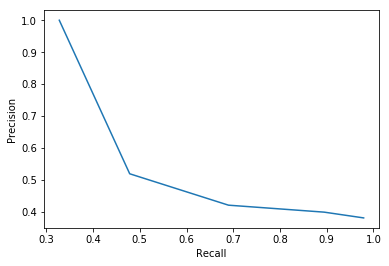

In [127]:
recall, precision = calc_precision_recall_plot(y_test, pred)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)

# SVM

In [128]:
classifier = SVC()
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

parameters_grid = {
    'C' : [0.1, 1, 5, 10, 100],
}

grid_cv = GridSearchCV(classifier, parameters_grid, cv=cv)


In [129]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 5, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [130]:
best_param = grid_cv.best_params_["C"]
best_param

100

In [131]:
pred = grid_cv.predict(X_test)

In [132]:
fbeta = metrics.precision_recall_fscore_support(y_test, pred)[2]

In [133]:
print (np.mean(metrics.precision_recall_fscore_support(y_test, pred)[0]))
print (np.mean(metrics.precision_recall_fscore_support(y_test, pred)[1]))
print (np.mean(fbeta))

0.4037562633763942
0.31400502845857853
0.3048332259893174


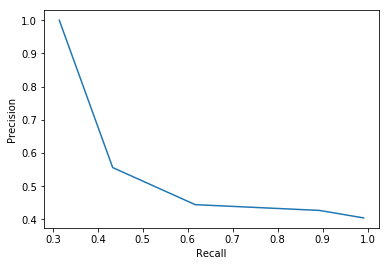

In [134]:
recall, precision = calc_precision_recall_plot(y_test, pred)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)

# KNN

In [135]:
classifier = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

parameters_grid = {
    'n_neighbors' : [1, 2],
}

grid_cv = GridSearchCV(classifier, parameters_grid, cv=cv)


In [136]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [137]:
best_param = grid_cv.best_params_["n_neighbors"]
best_param

1

In [138]:
pred = grid_cv.predict(X_test)

In [139]:
fbeta = metrics.precision_recall_fscore_support(y_test, pred)[2]

In [140]:
print (np.mean(metrics.precision_recall_fscore_support(y_test, pred)[0]))
print (np.mean(metrics.precision_recall_fscore_support(y_test, pred)[1]))
print (np.mean(fbeta))

0.3510735678392223
0.3456457717212838
0.34688600271348785


f-мера - 0.34688600271348785, оптимальный параметр n_neighbors - 1

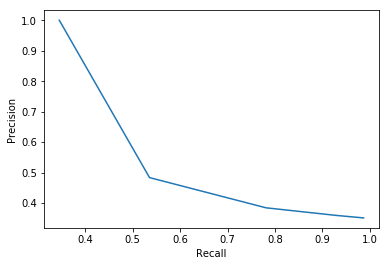

In [141]:
recall, precision = calc_precision_recall_plot(y_test, pred)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)

# Decision Tree

In [142]:
classifier = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

parameters_grid = {
    'max_depth' : [2, 3, 5],
    'min_samples_split': [2,5]
}

grid_cv = GridSearchCV(classifier, parameters_grid, cv=cv)


In [143]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 5], 'min_samples_split': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [144]:
best_param = grid_cv.best_params_["max_depth"]
print(best_param)
best_param = grid_cv.best_params_["min_samples_split"]
print(best_param)

5
2


In [145]:
pred = grid_cv.predict(X_test)

In [146]:
fbeta = metrics.precision_recall_fscore_support(y_test, pred)[2]

In [147]:
print (np.mean(metrics.precision_recall_fscore_support(y_test, pred)[0]))
print (np.mean(metrics.precision_recall_fscore_support(y_test, pred)[1]))
print (np.mean(fbeta))

0.347137658373689
0.262932865301128
0.22534673086881848


In [148]:
metrics.precision_recall_fscore_support(y_test, pred)[0]

array([0.28571429, 0.2557652 , 0.36363636, 0.26229508, 0.45454545,
       0.46086957])

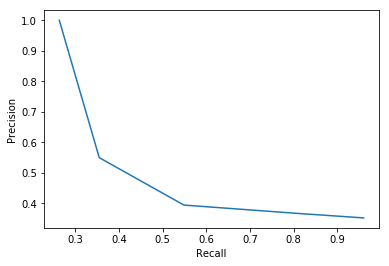

In [149]:
recall, precision = calc_precision_recall_plot(y_test, pred)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)

# Таблица результатов

In [150]:
#| metrics   | LogisticRegression | KNN | Decision Tree |
#|-----------|:-------------:|--------:|-----------------:|
#| precision |  0.22568      | 0.19953 |    0.12557       |
#| recall    |  0.21023      | 0.19261 |    0.19335       |
#| fscore    |  0.17647      | 0.17539 |    0.12851       |

# Оптимальные параметры моделей

LogisticRegression: C = 1

SVM: C=100

KNN: C=1

Decision Tree: max_depth = 5, min_samples_split = 2

# Precision-recall кривые

In [118]:
def calc_precision_recall(y_test, predict, threesold):
    y_test = [y_test[key] for key in y_test.keys()]
    predict = list(predict)
    tp = [0, 0, 0, 0, 0, 0]
    fp = [0, 0, 0, 0, 0, 0]
    fn = [0, 0, 0, 0, 0, 0]
    for i in range(0, len(y_test)-1):
        if (abs(y_test[i] - predict[i]) <= threesold):
            if (y_test[i] == predict[i]):
                tp[int(y_test[i])] += 1
            else:
                fp[int(predict[i])] += 1
        else:
            fn[int(y_test[i])] += 1
    
    precision = 0
    recall = 0
    for i in range(0, len(tp)):
        precision += tp[i]/(6.0 * (tp[i] + fp[i]))
        recall += tp[i]/(6.0 * (tp[i] + fn[i]))
    return precision, recall

In [119]:
def calc_precision_recall_plot(y_test, predict):
    precision = []
    recall = []
    for i in range(0, 5):
        p, r = calc_precision_recall(y_test, predict, i)
        precision.append(p)
        recall.append(r)
    return recall, precision